# Fine tuning the T5 for text summarization
## T5
- It is a text to text transfer transformer. 
- T5 alone can be used to perform different NLP taska such as Text classification, language translation, text summarization, question answering makes itself a most flexible model.

**What it does?**  
1. Convert all problems to text to text generation.
    - For example: In Language Translation, English to Italian  
    Input: I love you  
    Output: Ti amo
    
    - For example: In Text Classification,  
    Input: This product is trash.  
    Output: Negative

2. Learns to predict [MASK] words.
3. Use task specific prefixes to guide the model during fine tuning.
   For example, it adds specific token at the beginning of the input text to indicate what  task is it performing.

T5 has been shown to achieve state-of-the-art results on a wide range of NLP tasks, and it’s considered a highly sophisticated and powerful NLP model, showing a high level of versatility, fine-tuning capability, and an efficient way to transfer knowledge.

There are 2 summarization types:

1. `Extractive Summarization:` Extractive summarization involves identifying and extracting key phrases, sentences, or segments directly from the original text to form a condensed version. It's akin to highlighting parts of the text that are deemed most informative or relevant.

2. `Abtractive Summarization:` Abstractive summarization goes beyond mere extraction; it involves understanding the main ideas and then expressing them in new words. It's akin to reading a text and then explaining it in one's own words.

What we gonna do is Abtractive Summarization.

# Implementation

## 1. Installations

In [1]:
!pip install datasets evaluate transformers rouge nltk

  Obtaining dependency information for evaluate from https://files.pythonhosted.org/packages/70/63/7644a1eb7b0297e585a6adec98ed9e575309bb973c33b394dae66bc35c69/evaluate-0.4.1-py3-none-any.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 4.7 MB/s eta 0:00:00


If you're opening this notebook locally, make sure your environment has an install from the last version of those libraries.Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

Make sure your version of Transformers is at least 4.11.0 since the functionality was introduced in that version:

In [2]:
import transformers

print(transformers.__version__)

4.35.0


## 2. Imports

In [3]:
import datasets
import transformers
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import torch
import warnings


from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from transformers import T5Tokenizer, T5ForConditionalGeneration, AutoTokenizer, AutoModel
from transformers import DataCollatorForSeq2Seq, AdamW, get_linear_schedule_with_warmup
from transformers import AutoModelForSeq2SeqLM, Seq2SeqTrainingArguments, Seq2SeqTrainer
from transformers import create_optimizer, AdamWeightDecay
from transformers import pipeline
from datasets import Dataset, DatasetDict
from tqdm.auto import tqdm
from rouge import Rouge

warnings.filterwarnings("ignore") 

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [4]:
from torch import cuda
device = 'cuda' if cuda.is_available() else 'cpu'
print(device)

cuda


## 3. Load dataset
We will using the news summary dataset from [🤗 kaggle](https://www.kaggle.com/datasets/sunnysai12345/news-summary).

In [5]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/news_summary_more.csv
/kaggle/input/news_summary.csv


In [6]:
df = pd.read_csv("/kaggle/input/news_summary.csv", encoding="latin-1")
df.head()

,author,date,headlines,read_more,text,ctext
0,Chhavi Tyagi,"03 Aug 2017,Thursday",Daman & Diu revokes mandatory Rakshabandhan in...,http://www.hindustantimes.com/india-news/raksh...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Daisy Mowke,"03 Aug 2017,Thursday",Malaika slams user who trolled her for 'divorc...,http://www.hindustantimes.com/bollywood/malaik...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,Arshiya Chopra,"03 Aug 2017,Thursday",'Virgin' now corrected to 'Unmarried' in IGIMS...,http://www.hindustantimes.com/patna/bihar-igim...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Sumedha Sehra,"03 Aug 2017,Thursday",Aaj aapne pakad liya: LeT man Dujana before be...,http://indiatoday.intoday.in/story/abu-dujana-...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Aarushi Maheshwari,"03 Aug 2017,Thursday",Hotel staff to get training to spot signs of s...,http://indiatoday.intoday.in/story/sex-traffic...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [7]:
df.describe()

,author,date,headlines,read_more,text,ctext
count,4514,4514,4514,4514,4514,4396
unique,45,240,4514,4461,4514,4341
top,Chhavi Tyagi,"19 Jul 2017,Wednesday",Daman & Diu revokes mandatory Rakshabandhan in...,http://indiatoday.intoday.in/story/assembly-el...,The Administration of Union Territory Daman an...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,559,76,1,13,1,13


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4514 entries, 0 to 4513
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   author     4514 non-null   object
 1   date       4514 non-null   object
 2   headlines  4514 non-null   object
 3   read_more  4514 non-null   object
 4   text       4514 non-null   object
 5   ctext      4396 non-null   object
dtypes: object(6)
memory usage: 211.7+ KB


In [9]:
df = df[['headlines', 'text', 'ctext']]
df.head()

,headlines,text,ctext
0,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...,The Daman and Diu administration on Wednesday ...
1,Malaika slams user who trolled her for 'divorc...,Malaika Arora slammed an Instagram user who tr...,"From her special numbers to TV?appearances, Bo..."
2,'Virgin' now corrected to 'Unmarried' in IGIMS...,The Indira Gandhi Institute of Medical Science...,The Indira Gandhi Institute of Medical Science...
3,Aaj aapne pakad liya: LeT man Dujana before be...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...,Lashkar-e-Taiba's Kashmir commander Abu Dujana...
4,Hotel staff to get training to spot signs of s...,Hotels in Maharashtra will train their staff t...,Hotels in Mumbai and other Indian cities are t...


In [10]:
# drop na
df = df.dropna()
df.describe()

,headlines,text,ctext
count,4396,4396,4396
unique,4396,4396,4341
top,Daman & Diu revokes mandatory Rakshabandhan in...,The Administration of Union Territory Daman an...,AAJ TAK LIVE TV WITH LIVE ELECTION RESULTS I c...
freq,1,1,13


In [11]:
# Converting to lowercase
df['ctext'] = df['ctext'].apply(str.lower)
df['text'] = df['text'].apply(str.lower)
df['headlines'] = df['headlines'].apply(str.lower)
df.head()

,headlines,text,ctext
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo..."
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


In [12]:
df['headlines_length'] = [len(x.split()) for x in df.headlines]
df['text_length'] = [len(x.split()) for x in df.text]
df['ctext_length'] = [len(x.split()) for x in df.ctext]
df.head()

,headlines,text,ctext,headlines_length,text_length,ctext_length
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...,9,60,364
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo...",10,60,396
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...,8,60,335
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...,10,60,404
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...,11,60,526


In [13]:
# only select the row where ctext length is greater than text length
df = df[df['ctext_length'] >= df['text_length']]
df.describe()

,headlines_length,text_length,ctext_length
count,4274.000000,4274.000000,4274.000000
mean,9.300889,58.299719,351.740056
std,1.407168,2.314246,358.884472
min,4.000000,44.000000,50.000000
25%,8.000000,57.000000,193.000000
50%,9.000000,59.000000,288.000000
75%,10.000000,60.000000,416.000000
max,14.000000,62.000000,12202.000000


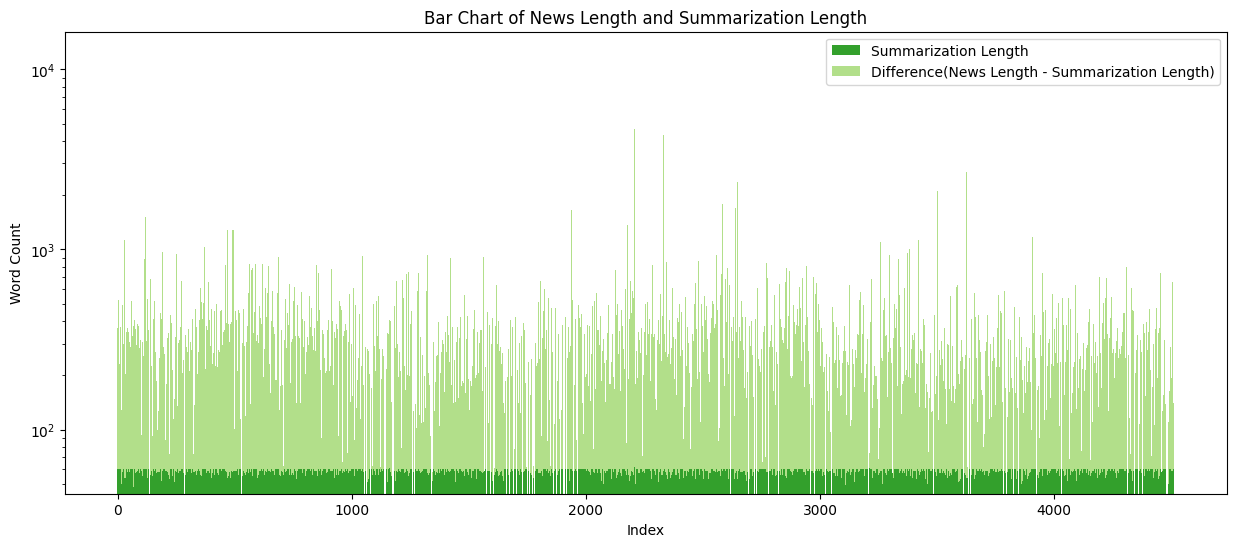

In [14]:
df['diff'] = df['ctext_length'] - df['text_length']
#sns.set(style="whitegrid")
color1 = sns.color_palette("Paired")[3] 
color2 = sns.color_palette("Paired")[2]  

plt.figure(figsize=(15, 6))
bar1 = plt.bar(df.index, df['text_length'], color=color1, label='Summarization Length', width=1.0)
bar2 = plt.bar(df.index, df['diff'], bottom=df['text_length'], color=color2, label='Difference(News Length - Summarization Length)', width=1.0)

plt.xlabel('Index')
plt.ylabel('Word Count')
plt.title('Bar Chart of News Length and Summarization Length')
plt.legend()
plt.yscale('log')
plt.show()

In [15]:
df = df.drop(columns=['headlines_length', 'text_length', 'ctext_length', 'diff'])
df.head()

,headlines,text,ctext
0,daman & diu revokes mandatory rakshabandhan in...,the administration of union territory daman an...,the daman and diu administration on wednesday ...
1,malaika slams user who trolled her for 'divorc...,malaika arora slammed an instagram user who tr...,"from her special numbers to tv?appearances, bo..."
2,'virgin' now corrected to 'unmarried' in igims...,the indira gandhi institute of medical science...,the indira gandhi institute of medical science...
3,aaj aapne pakad liya: let man dujana before be...,lashkar-e-taiba's kashmir commander abu dujana...,lashkar-e-taiba's kashmir commander abu dujana...
4,hotel staff to get training to spot signs of s...,hotels in maharashtra will train their staff t...,hotels in mumbai and other indian cities are t...


In [16]:
df['news'] = df['headlines'] + '. ' + df['ctext'] # adding headlines and ctext to make a whole news
df.rename(columns={"text": "summary"}, inplace = True) # the text column is summary of the text
df = df.drop(columns=['headlines', 'ctext'])
df.head()

,summary,news
0,the administration of union territory daman an...,daman & diu revokes mandatory rakshabandhan in...
1,malaika arora slammed an instagram user who tr...,malaika slams user who trolled her for 'divorc...
2,the indira gandhi institute of medical science...,'virgin' now corrected to 'unmarried' in igims...
3,lashkar-e-taiba's kashmir commander abu dujana...,aaj aapne pakad liya: let man dujana before be...
4,hotels in maharashtra will train their staff t...,hotel staff to get training to spot signs of s...


Making the dataset

In [17]:
# Making the dataset
prefix = 'summarize: ' # need to remind the T5 which types of task to perform
df['news'] = prefix + df['news']
df.head()

,summary,news
0,the administration of union territory daman an...,summarize: daman & diu revokes mandatory raksh...
1,malaika arora slammed an instagram user who tr...,summarize: malaika slams user who trolled her ...
2,the indira gandhi institute of medical science...,summarize: 'virgin' now corrected to 'unmarrie...
3,lashkar-e-taiba's kashmir commander abu dujana...,summarize: aaj aapne pakad liya: let man dujan...
4,hotels in maharashtra will train their staff t...,summarize: hotel staff to get training to spot...


In [18]:
df

,summary,news
0,the administration of union territory daman an...,summarize: daman & diu revokes mandatory raksh...
1,malaika arora slammed an instagram user who tr...,summarize: malaika slams user who trolled her ...
2,the indira gandhi institute of medical science...,summarize: 'virgin' now corrected to 'unmarrie...
3,lashkar-e-taiba's kashmir commander abu dujana...,summarize: aaj aapne pakad liya: let man dujan...
4,hotels in maharashtra will train their staff t...,summarize: hotel staff to get training to spot...
...,...,...
4509,fruit juice concentrate maker rasna is eyeing ...,summarize: rasna seeking ?250 cr revenue from ...
4510,former indian cricketer sachin tendulkar atten...,summarize: sachin attends rajya sabha after qu...
4511,"aamir khan, while talking about reality shows ...",summarize: shouldn't rob their childhood: aami...
4512,the maharashtra government has initiated an in...,"summarize: asha bhosle gets ?53,000 power bill..."


Now, we have to convert the pandas dataset to huggingface dataset.

In [19]:
dataset = datasets.Dataset.from_pandas(df)
dataset = dataset.remove_columns(["__index_level_0__"])

In [20]:
print(dataset)

Dataset({
    features: ['summary', 'news'],
    num_rows: 4274
})


Split data into train and val

In [21]:
train_df = dataset.train_test_split(test_size=0.2, shuffle=True) # split train and test
print(train_df)

DatasetDict({
    train: Dataset({
        features: ['summary', 'news'],
        num_rows: 3419
    })
    test: Dataset({
        features: ['summary', 'news'],
        num_rows: 855
    })
})


In [22]:
# Fitting into dataset dict
train_test_dataset = DatasetDict({
    'train': train_df["train"],
    'val': train_df['test']})

print(type(train_test_dataset))
train_test_dataset

<class 'datasets.dataset_dict.DatasetDict'>


DatasetDict({
    train: Dataset({
        features: ['summary', 'news'],
        num_rows: 3419
    })
    val: Dataset({
        features: ['summary', 'news'],
        num_rows: 855
    })
})

In [23]:
# tokenize the data
model_name = "t5-base"
tokenizer = AutoTokenizer.from_pretrained(model_name)

In [24]:
def prepare_dataset(data):
    inputs = data["news"]
    model_inputs = tokenizer(inputs, max_length=512, truncation=True)
    labels = tokenizer(text_target=data["summary"], max_length=128, truncation=True)
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [25]:
tokenized_data = train_test_dataset.map(prepare_dataset, batched=True)

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [26]:
tokenized_data["train"]

Dataset({
    features: ['summary', 'news', 'input_ids', 'attention_mask', 'labels'],
    num_rows: 3419
})

Now create a batch of examples using [DataCollatorForSeq2Seq](https://huggingface.co/docs/transformers/v4.35.0/en/main_classes/data_collator#transformers.DataCollatorForSeq2Seq). It’s more efficient to dynamically pad the sentences to the longest length in a batch during collation, instead of padding the whole dataset to the maximum length.

In [27]:
# Padding
data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model_name)

In [28]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    result = Rouge().get_scores(decoded_preds, decoded_labels, avg=True, ignore_empty=True)

    return result

## 4. Prepare Model and Train

In [29]:
# prepare the model
T5model = AutoModelForSeq2SeqLM.from_pretrained(model_name).to(device)

In [30]:
model_name = model_name.split("/")[-1]
print(model_name)

t5-base


In [37]:
# set up hyper-parameters
batch_size = 8
training_args = Seq2SeqTrainingArguments(
    output_dir=f"{model_name}-finetuned-news",
    evaluation_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=7,
    predict_with_generate=True,
    fp16=True,
    report_to="none"
)

Then we just need to pass all of this along with our datasets to the `Seq2SeqTrainer`:

In [38]:
# setup trainer
trainer = Seq2SeqTrainer(
    model = T5model,
    args = training_args,
    train_dataset = tokenized_data["train"],
    eval_dataset = tokenized_data["val"],
    tokenizer = tokenizer,
    data_collator = data_collator,
    compute_metrics = compute_metrics
)

In [39]:
trainer.train()

Epoch,Training Loss,Validation Loss,Rouge-1,Rouge-2,Rouge-l
1,No log,1.313084,"{'r': 0.15219944455234966, 'p': 0.6607447602468244, 'f': 0.2448645280912182}","{'r': 0.06781514985765741, 'p': 0.37640653874658025, 'f': 0.11376132124333403}","{'r': 0.14167866524878925, 'p': 0.6164226497998431, 'f': 0.22803367125980994}"
2,No log,1.285858,"{'r': 0.15499279403280522, 'p': 0.6749315335125453, 'f': 0.2495344042330294}","{'r': 0.07135527462869222, 'p': 0.39720444311259623, 'f': 0.11974659249734317}","{'r': 0.14497671650175262, 'p': 0.6329523303207518, 'f': 0.23352126366785123}"
3,1.434400,1.269046,"{'r': 0.15691680714371542, 'p': 0.6858298764645518, 'f': 0.2527775351753527}","{'r': 0.07288484676928411, 'p': 0.40883435917749655, 'f': 0.12241951821131832}","{'r': 0.14632749348318583, 'p': 0.64139217450363, 'f': 0.23583201197767184}"
4,1.434400,1.262950,"{'r': 0.15736153080702062, 'p': 0.6873108703397663, 'f': 0.2534039412332056}","{'r': 0.07343489810191847, 'p': 0.41157970512459685, 'f': 0.12330558753847923}","{'r': 0.1468879001050442, 'p': 0.6430792456024657, 'f': 0.23663334496832406}"
5,1.333500,1.258250,"{'r': 0.15763605187547786, 'p': 0.6895156457462961, 'f': 0.25395919356168406}","{'r': 0.07367622467165223, 'p': 0.41343537048129414, 'f': 0.12372878205905617}","{'r': 0.1469295604145481, 'p': 0.6442288270152051, 'f': 0.23680345352076013}"
6,1.333500,1.255445,"{'r': 0.15811468747900473, 'p': 0.6926828700100117, 'f': 0.2548082809645162}","{'r': 0.07425153915558538, 'p': 0.41657995169605083, 'f': 0.12470036276435664}","{'r': 0.14751621287236552, 'p': 0.6474100593631041, 'f': 0.2378076590110538}"
7,1.333500,1.254682,"{'r': 0.15798263290387096, 'p': 0.6920416366494803, 'f': 0.2545864062613433}","{'r': 0.0739992414656197, 'p': 0.4154233110657259, 'f': 0.12429581165578805}","{'r': 0.14725260189054024, 'p': 0.6462795719168273, 'f': 0.23737794170233703}"


TrainOutput(global_step=1498, training_loss=1.3527983193085573, metrics={'train_runtime': 3000.3047, 'train_samples_per_second': 7.977, 'train_steps_per_second': 0.499, 'total_flos': 1.457418919477248e+16, 'train_loss': 1.3527983193085573, 'epoch': 7.0})

## 5. Evaluate Model

In [40]:
trainer.evaluate()

{'eval_loss': 1.2546818256378174,
 'eval_rouge-1': {'r': 0.15798263290387096,
  'p': 0.6920416366494803,
  'f': 0.2545864062613433},
 'eval_rouge-2': {'r': 0.0739992414656197,
  'p': 0.4154233110657259,
  'f': 0.12429581165578805},
 'eval_rouge-l': {'r': 0.14725260189054024,
  'p': 0.6462795719168273,
  'f': 0.23737794170233703},
 'eval_runtime': 89.6224,
 'eval_samples_per_second': 9.54,
 'eval_steps_per_second': 0.603,
 'epoch': 7.0}

## 6. Save the Model

In [41]:
model_path = "t5-finetuned-news"
trainer.save_model(model_path)
tokenizer.save_pretrained(model_path)

('t5-finetuned-news/tokenizer_config.json',
 't5-finetuned-news/special_tokens_map.json',
 't5-finetuned-news/spiece.model',
 't5-finetuned-news/added_tokens.json',
 't5-finetuned-news/tokenizer.json')

## 6. Inference
Try the fine-tuned T5 model for our news test set!

In [42]:
# load the model
model = AutoModelForSeq2SeqLM.from_pretrained("t5-finetuned-news")
tokenizer = AutoTokenizer.from_pretrained("t5-finetuned-news")

In [46]:
news = ["In a significant breakthrough for medical science, researchers at the forefront of cancer treatment have unveiled a groundbreaking new drug that shows promise in combating various forms of cancer. The drug, named OncolyteX, has undergone rigorous testing in preclinical trials, demonstrating remarkable efficacy in shrinking tumors and improving patient outcomes.Led by a team of renowned oncologists and molecular biologists at the prestigious Genetica Research Institute, the development of OncolyteX represents a leap forward in the fight against cancer. Unlike conventional chemotherapy drugs that indiscriminately target both healthy and cancerous cells, OncolyteX is designed to selectively attack cancer cells while leaving healthy tissues unharmed, thereby minimizing adverse side effects.",
        "The urgency of addressing climate change has taken center stage as world leaders, policymakers, and activists gather for the United Nations Climate Summit in New York. Against a backdrop of escalating environmental threats and unprecedented climate-related disasters, the summit aims to galvanize global action and accelerate efforts to mitigate the impacts of climate change. With rising temperatures, extreme weather events, and melting ice caps becoming increasingly apparent, the need for bold and decisive action has never been greater. The latest report from the Intergovernmental Panel on Climate Change (IPCC) underscores the severity of the crisis, warning of catastrophic consequences if urgent measures are not taken to reduce greenhouse gas emissions and transition to a sustainable, low-carbon economy. In his keynote address to the summit delegates, UN Secretary-General Antonio Guterres issued a stark warning, urging world leaders to 'listen to the science' and take concrete steps to limit global warming to well below 2 degrees Celsius above pre-industrial levels, as outlined in the Paris Agreement.",
        ]

for i in range(len(news)):
    print("original_news: ", news[i])
    summarizer = pipeline("summarization", model = model, tokenizer = tokenizer, max_length = 100)
    summary = summarizer(news[i])
    print()
    print(summary[0])
    print()


original_news:  In a significant breakthrough for medical science, researchers at the forefront of cancer treatment have unveiled a groundbreaking new drug that shows promise in combating various forms of cancer. The drug, named OncolyteX, has undergone rigorous testing in preclinical trials, demonstrating remarkable efficacy in shrinking tumors and improving patient outcomes.Led by a team of renowned oncologists and molecular biologists at the prestigious Genetica Research Institute, the development of OncolyteX represents a leap forward in the fight against cancer. Unlike conventional chemotherapy drugs that indiscriminately target both healthy and cancerous cells, OncolyteX is designed to selectively attack cancer cells while leaving healthy tissues unharmed, thereby minimizing adverse side effects.

{'summary_text': 'researchers at the forefront of cancer treatment have unveiled a groundbreaking new drug that shows promise in combating various forms of cancer. the drug, named Oncol

### Conclusion


You can further experiment on this.